<a href="https://colab.research.google.com/github/avengercelona/BIOMIL/blob/main/bioML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers,models,optimizers,losses
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory,image

import matplotlib.pyplot as plt

In [10]:
# Check if running on Google Colab or Local Host
try:
    import google.colab
    on_colab = True
except ImportError:
    on_colab = False

if on_colab:
    train_dir='/content/drive/MyDrive/Colab Notebooks/Dataset/training'
    val_dir='/content/drive/MyDrive/Colab Notebooks/Dataset/validation'
    save_dir='/content/drive/MyDrive/Colab Notebooks/Resources/'
    print("Running on Google Colab. Training directory set to:", train_dir)
    # Import Colab-specific libraries if needed
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

else:
    train_dir = 'Capsule-Vision-2024-Challenge/Dataset/training'
    val_dir =   'Capsule-Vision-2024-Challenge/Dataset/validation'
    save_dir = 'Capsule-Vision-2024-Challenge/Dataset/'
    print("Running on Local Host. Training directory set to:", train_dir)


Running on Google Colab. Training directory set to: /content/drive/MyDrive/Colab Notebooks/Dataset/training
Mounted at /content/drive


In [13]:
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',  # Use categorical for one-hot labels, 'int' for class indices
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,  # Shuffle the dataset
    seed=123       # Seed for reproducibility
)

# Loading the validation dataset
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',  # Use 'categorical' if using one-hot encoded labels
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False  # Do not shuffle validation data
)

Found 37607 files belonging to 10 classes.
Found 16132 files belonging to 10 classes.


In [11]:
img_height = 224
img_width = 224

batch_size = 32
epochs = 30
optimizer='adam'
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Num GPUs Available:  1
Default GPU Device: /device:GPU:0


In [9]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True
model = models.Sequential()

model.add(base_model)
model.add(layers.Reshape((49, 1280)))  # Ensure it matches your LSTM input requirement

model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

input_tensor = tf.keras.Input(shape=(224, 224, 3))
output_tensor = model(input_tensor)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 49, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 49, 64)              │         344,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,409,069 (16.82 MB)

 Trainable params: 4,367,046 (16.66 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
'''
input_shape = (224, 224, 3)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2))) # outut shape (26, 26, 128)

model.add(layers.Flatten()) # output shape (26*26*128,)

model.add(layers.Reshape((676, 128)))  # Example reshape (assuming timesteps=28 and features=128)

# LSTM layer to capture temporal relationships in the feature maps
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.LSTM(32))

# Fully connected layers for classification
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

# Output layer: 10 classes (for classification)
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()
'''

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = train_ds.take(250).cache().prefetch(buffer_size=AUTOTUNE)
validation_data = val_ds.take(25).cache().prefetch(buffer_size=AUTOTUNE)

for images, labels in training_data.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 10)


In [15]:
history = model.fit(training_data, epochs=epochs, validation_data=validation_data)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2380s 9s/step - accuracy: 0.7221 - loss: 1.0811 - val_accuracy: 0.1562 - val_loss: 2.8784
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 104s 332ms/step - accuracy: 0.7791 - loss: 0.7088 - val_accuracy: 0.2237 - val_loss: 2.9564
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 331ms/step - accuracy: 0.8005 - loss: 0.6253 - val_accuracy: 0.2800 - val_loss: 2.3968
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 331ms/step - accuracy: 0.8131 - loss: 0.5699 - val_accuracy: 0.3988 - val_loss: 1.7282
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 330ms/step - accuracy: 0.8312 - loss: 0.5141 - val_accuracy: 0.3950 - val_loss: 1.7942
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 333ms/step - accuracy: 0.8414 - loss: 0.4891 - val_accuracy: 0.3225 - val_loss: 2.5820
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 332ms/step - accuracy: 0.8462 - loss: 0.4698 - val_accuracy: 0.3275 - val_loss: 2.1825
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 336ms/step - accuracy: 0.8386 - loss

In [16]:
from google.colab import files
model.save(save_dir+'efc_model.keras')  # Save locally first
if on_colab:
    files.download(save_dir+'efc_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
train_loss, train_accuracy, val_loss, val_accuracy = [], [], [], []

In [18]:
train_loss.extend(history.history['loss'])
train_accuracy.extend(history.history['accuracy'])
val_loss.extend(history.history['val_loss'])
val_accuracy.extend(history.history['val_accuracy'])


In [20]:
train_loss_np = np.array(train_loss)
train_accuracy_np = np.array(train_accuracy)
val_loss_np = np.array(val_loss)
val_accuracy_np = np.array(val_accuracy)


# Save to files
np.save("efc_train_loss", train_loss_np)
np.save("efc_train_accuracy", train_accuracy_np)
np.save("efc_val_loss", val_loss_np)
np.save("efc_val_accuracy", val_accuracy_np)

# Download the files
from google.colab import files
files.download('efc_train_loss.npy')
files.download('efc_train_accuracy.npy')
files.download('efc_val_loss.npy')
files.download('efc_val_accuracy.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

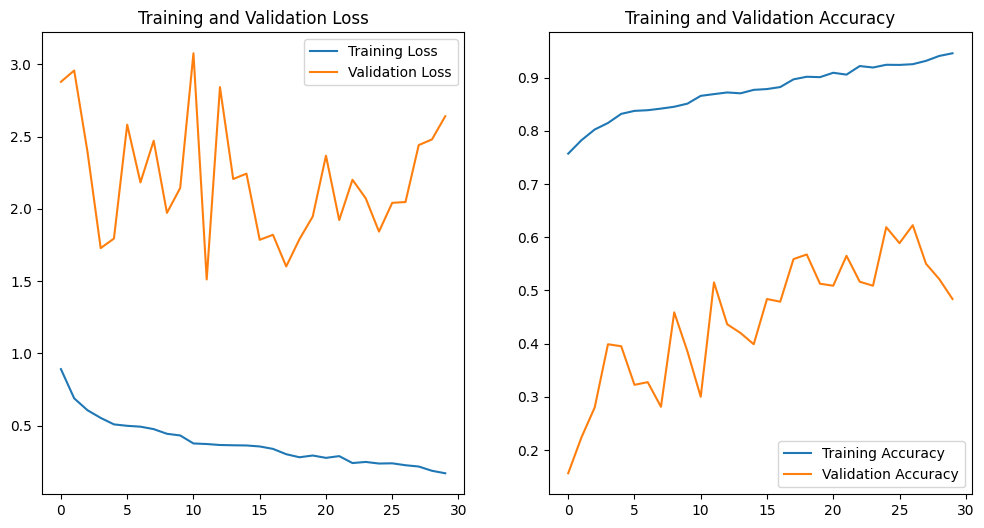

In [19]:


# Plotting training & validation loss and accuracy
epochs_range = range(len(train_loss))

# Plot Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()